In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import pickle
import numpy as np
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.ndimage
import pandas as pd

import neurokit2 as nk

#Extracting the data from the 
data_set_path = "D:\Downloads\WESAD\WESAD\\"
subject = ["S2",'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17']

class read_data_of_one_subject:
    """Read data from WESAD dataset"""
    def __init__(self, path, subject):
        self.keys = ['label', 'subject', 'signal']
        self.signal_keys = ['wrist', 'chest']
        self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
        self.wrist_sensor_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        #os.chdir(path)
        #os.chdir(subject)
        with open(path + subject +'/'+subject + '.pkl', 'rb') as file:
            data = pickle.load(file, encoding='latin1')
        self.data = data

    def get_labels(self):
        return self.data[self.keys[0]]

    def get_wrist_data(self):
        """"""
        #label = self.data[self.keys[0]]
        assert subject == self.data[self.keys[1]]
        signal = self.data[self.keys[2]]
        wrist_data = signal[self.signal_keys[0]]
        #wrist_ACC = wrist_data[self.wrist_sensor_keys[0]]
        #wrist_ECG = wrist_data[self.wrist_sensor_keys[1]]
        return wrist_data

    def get_chest_data(self):
        """"""
        signal = self.data[self.keys[2]]
        chest_data = signal[self.signal_keys[1]]
        return chest_data

21000 size of the samples
20 ttot1
(21000,) total base shape
(21000, 20) Total stress
20 ttot2
(1, 18) HRV 1


C:\Users\jortr\AppData\Local\Temp\ipykernel_4016\2032159797.py:84: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  hrv_b=hrv_b.dropna(1)


'   HRV_MeanNN   HRV_SDNN  HRV_RMSSD   HRV_SDSD  HRV_CVNN  HRV_CVSD  HRV_MedianNN  HRV_MadNN  HRV_MCVNN  HRV_IQRNN  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20   HRV_MinNN   HRV_MaxNN  HRV_HTI  HRV_TINN\n0  704.390244  72.383185  51.700669  52.356854   0.10276  0.073398    684.285714      52.95    0.07738  82.857143   651.428571   738.571429  14.634146  56.097561  584.285714  871.428571    5.125   70.3125'

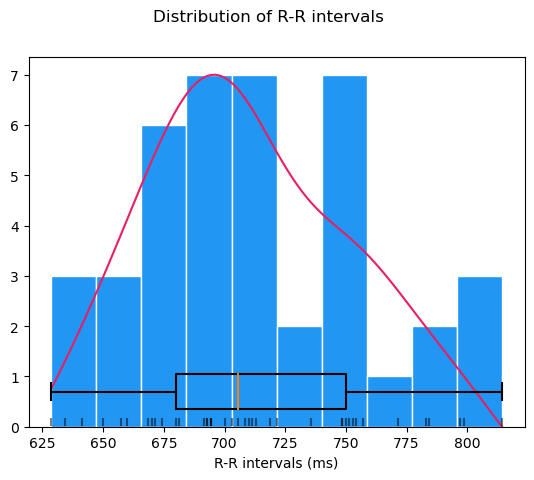

In [7]:
from ECG import ECGprep
from ECG import ECGfeatures

import sys
sys.path.insert(1, 'D:\Documents\GitHub\EPO-4_BioBombs\Machine learning')

ecg_features = np.asarray([0, 0, 0, 0], dtype="float")


########################################################
#Extracting the data
for i in range(1):       #len(subject)
    obj_data = {}

    obj_data[subject[i]] = read_data_of_one_subject(data_set_path, subject[i])
    # print(obj_data[subject[i]].data)
    chest_data_dict = obj_data[subject[i]].get_chest_data()

    labels = obj_data[subject[i]].get_labels()
    baseline = np.asarray([idx for idx, val in enumerate(labels) if val == 1])
    stress = np.asarray([idx for idx, val in enumerate(labels) if val == 2])

    ecg_stress = chest_data_dict['ECG'][stress, 0]
    ecg_base = chest_data_dict['ECG'][baseline, 0]

    fs = 700 #sampling freq.

    #########################################################
    #cut a smaller window
    wdw=int(0.5*60*fs)
    size_adpt=int(len(stress)/(len(stress)/(int(wdw))))

    print(size_adpt, "size of the samples")
    t_tot = (len(stress)//(int(wdw)))
    ecg_stress_tot = np.zeros([size_adpt, t_tot])
    ecg_base_tot = np.zeros([size_adpt, t_tot])
    print(t_tot, 'ttot1')

    for i in range(t_tot):
        ecg1 = ecg_stress[i*int(wdw):(i+1)*int(wdw)]
        ecg2 = ecg_base[i*int(wdw):(i+1)*int(wdw)]
        t1 = np.arange(0, ecg1.size*(1/fs), (1/fs))
        t1 = t1[:ecg1.size]
        t2 = np.arange(0, ecg2.size*(1/fs), (1/fs))
        t2 = t2[:ecg2.size]
        ecg_stress_tot[:, i] = ecg1
        ecg_base_tot[:, i] = ecg2

    print(ecg2.shape, 'total base shape')
    print(ecg_stress_tot.shape, 'Total stress')

    ####################################################
    #Data perperation, i.e. filtering etc
    # ecg_filt_b = np.zeros((5, t_tot))
    # ecg_filt_s = np.zeros((5, t_tot))
    ECG_base = []
    ECG_stress = []
    print(t_tot, 'ttot2')

    # for i in range(t_tot):
    #     ECG_base = ECGprep(fs, ecg_base_tot[:,i], "baseline")
    #     ECG_stress = ECGprep(fs, ecg_stress_tot[:,i], "stress")

    #     ecg_filt_b = ECG_base.filtering_data()
    #     ecg_filt_s = ECG_stress.filtering_data()

    # print(ecg_filt_b.shape, 'filtering shape')

    #######################################################
    #Feature extraction, obtaining the peaks and getting the HRV time domain data.
    ECG_feat_base = pd.DataFrame()
    ECG_feat_stress = pd.DataFrame()
    for i in range (1):              #t_tot
        ECG_feat_base = nk.ecg_clean(ecg_base_tot[:, i], sampling_rate=fs)
        ECG_feat_stress= nk.ecg_clean(ecg_stress_tot[:, i], sampling_rate=fs)

        peaks_b, info_b = nk.ecg_peaks(ECG_feat_base, sampling_rate=fs, correct_artifacts=True)
        peaks_s, info_s = nk.ecg_peaks(ECG_feat_stress, sampling_rate=fs, correct_artifacts=True)

        #HRV time domain features only, no frequency or nonlinear measurements.
        hrv_b=nk.hrv_time(peaks_b, sampling_rate=fs, show=False)
        hrv_s=nk.hrv_time(peaks_s, sampling_rate=fs, show=True)

        hrv_b=hrv_b.dropna(1)
        #hrv_b=hrv_b.dropna()
        print(hrv_b.shape, 'HRV 1')
        display(hrv_b.to_string())
        
    # eda_features = np.vstack((ecg_features,ecg_feat_s))
    # eda_features = np.vstack((ecg_features,ecg_feat_b))
    #print(hrv_b, 'HRV 2')
    

# print('\n')
# print(ecg1.shape, ecg_stress_tot.shape, '1')
# print('\n')
# print(np.shape(ecg_filt_b), np.shape(ecg_filt_s),'2')
# #print(np.shape(ecg_feat_b), np.shape(ecg_feat_s))
 

 